<a href="https://colab.research.google.com/github/iakioh/MusiCAN/blob/main/models/first_music_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Settings

In [2]:
# Pianoroll parameters
notes_per_octave = 12
number_octaves = 6   # as in MuseGAN
number_pitches = number_octaves * notes_per_octave

number_bars = 1
beats_per_bar = 4   # 4/4 rythm
blips_per_beat = 24   # temporal resolution of Lakh dataset
number_blips  = number_bars * beats_per_bar * blips_per_beat

pianoroll_size = number_pitches * number_blips

print(f"pianoroll array: {number_pitches}x{number_blips} = {pianoroll_size}")


# Generator parameters
seed_length = 64


pianoroll array: 72x96 = 6912


## Data Preparation

### Mock data for model development

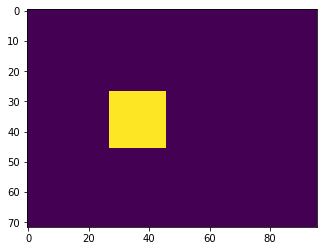

In [3]:
mock_image = torch.zeros(number_pitches, number_blips) #, dtype = torch.int)
for i in range(number_pitches) :
    for j in range(number_blips) :
        mock_image[i, j] = \
            (i < number_pitches // 2 + 10) and \
            (i > number_pitches // 2 - 10) and \
            (j < number_pitches // 2 + 10) and \
            (j > number_pitches // 2 - 10)

plt.imshow(mock_image);

# make a data_set by stacking the same image a number of times
number_images = 100
mock_vector   = mock_image.flatten()
mock_data     = mock_vector[None, :].expand(number_images, *mock_vector.size())
mock_labels   = torch.empty(number_images)
mock_data_set = torch.utils.data.TensorDataset(mock_data, mock_labels)

## Model

### Architecture

In [4]:
# code from https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight%2Dthrough%20estimator%20is,function%20was%20an%20identity%20function.

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class StraightThroughEstimator(torch.nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x

### Mini-GAN for testing

In [5]:
class Generator (torch.nn.Module) :
    """
    test GAN generator, MLP, one layer.

    input : normally distributed random vector of length I, seed vector
    output: binary vector of length O, pianoroll
    """


    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)
        
        I = seed_length   # length of input vector
        O = pianoroll_size    # length of output vector
        
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(I, I),
            torch.nn.ReLU(),
            torch.nn.Linear(I, O),
            StraightThroughEstimator()
        )

        if log :
            print(f"Generator:")
            print(f"    I: {I}, O: {O}")
            print(f"    layers: 2")
            print("")


    def forward (self, seed) :
        pianoroll = self.generator(seed)

        return pianoroll

In [6]:
class Discriminator (torch.nn.Module) :
    """
    first GAN discriminator, basically Generator in reverse but 
    
    input : binary vector of length I, pianoroll
    output: single number, prob. that the input is a real and not 
            generated pianoroll
    """


    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        I = pianoroll_size   # length of input vector
        O = 1   # length of output vector
        
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(I,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, O),
            torch.nn.Sigmoid()
        )

        if log :
            print(f"Discriminator:")
            print(f"    I: {I}, O: {O}")
            print(f"    layers: 2")
            print("")


    def forward (self, pianoroll):
        judgement = self.discriminator(pianoroll)
        return judgement

#### Main GAN

In [7]:
class Generator (torch.nn.Module) :
    """
    first GAN generator, MLP, layer size doubles until output size O is reached.

    input : normally distributed random vector of length I, seed vector
    output: binary vector of length O, pianoroll
    """


    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)
        
        I = seed_length   # length of input vector
        O = pianoroll_size    # length of output vector
        x = 4   # linear layer output_length/input_length ratio,
                # the higher x is, the fewer layers are needed to generate the 
                # output vector.

        layers = []
        current_size = I
        while x*current_size < O:
            layers.extend([
                torch.nn.Linear(current_size, x*current_size),
                torch.nn.BatchNorm1d(x*current_size),
                torch.nn.ReLU(),
            ])
            current_size *= x
        layers.extend([
            torch.nn.Linear(current_size, O),
            StraightThroughEstimator()
        ])

        self.generator = torch.nn.Sequential(*layers)

        if log :
            print(f"Generator:")
            print(f"    I: {I}, O: {O}")
            print(f"    layers: {(len(layers)+1) // 3}")
            print("")


    def forward (self, seed) :
        pianoroll = self.generator(seed)

        return pianoroll

In [8]:
class Discriminator (torch.nn.Module) :
    """
    first GAN discriminator, basically Generator in reverse but 
    
    input : binary vector of length I, pianoroll
    output: single number, prob. that the input is a real and not 
            generated pianoroll
    """


    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        I = pianoroll_size   # length of input vector
        O = 1   # length of output vector
        x = 4   # linear layer input_length/output_length ratio,
                # the higher x is, the fewer layers are needed to condense the 
                # input vector to a single number.

        layers = []
        layers.append(torch.nn.BatchNorm1d(I))
        current_size = I
        while current_size >= x**2*O :
            layers.extend([
                torch.nn.Linear(current_size, current_size//x),
                torch.nn.BatchNorm1d(current_size//x),
                torch.nn.ReLU(),
            ])
            current_size //= x
        layers.extend([
            torch.nn.Linear(current_size, O),
            #torch.nn.Sigmoid(),
        ])

        self.discriminator = torch.nn.Sequential(*layers)

        if log :
            print(f"Discriminator:")
            print(f"    I: {I}, O: {O}")
            print(f"    layers: {(len(layers)+1) // 3}")
            print("")


    def forward (self, pianoroll):
        judgement = self.discriminator(pianoroll)
        return judgement

#### Architecture Tests

Generator:
    I: 64, O: 6912
    layers: 4



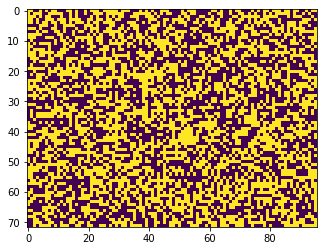

In [9]:
gen = Generator(log=True)

gen_out = gen.forward(torch.rand((5, seed_length)))
pr = gen_out.cpu().detach().numpy()
pr = pr.reshape((5, number_pitches, number_blips))

plt.imshow(pr[0]);

In [10]:
dis = Discriminator(log=True)

dis_out = dis.forward(gen_out)
judge = torch.sigmoid(dis_out).cpu().detach().numpy().flatten()

print(f"Prob. that image is real: {judge[0]*100:.0f}%")


Discriminator:
    I: 6912, O: 1
    layers: 6

Prob. that image is real: 29%


#### Training Test Helper Functions

In [11]:
def quick_test(GEN, DIS, data = mock_data): 
    
    # Test on generated data
    
    ## Generator
    test_seeds = torch.normal(0, 1, (5, 64))
    examples = GEN.forward(test_seeds)
    gen_img = examples[0].reshape(number_pitches, number_blips)
    gen_img = gen_img.detach().numpy()

    ## Discriminator
    gen_judgements = DIS.forward(examples)
    gen_judgement = torch.sigmoid(gen_judgements[0][0]).detach().numpy()

    # Results
    plt.title("Generator output x")
    plt.imshow(gen_img);
    print(f"Discriminator p(x_gen = real): {gen_judgement*100:.0f}%")

    # Test on real data
    real_judgement = torch.sigmoid(DIS.forward(data))[0][0].detach().numpy()
    print(f"Discriminator p(x_real = real) = {real_judgement*100:.0f}%")


In [12]:
def generator_goodness(generated_batch, real_batch):
    """ compare two batches of data by calculating the absolute mean difference"""
    
    # averaged over batches 
    generated_mean = torch.mean(generated_batch)
    real_mean = torch.mean(real_batch)

    # take differnece & absolut value, average over features lastly
    goodness_criteria = torch.mean(torch.abs(real_mean - generated_mean))

    return(goodness_criteria.detach().numpy())


### Training

In [18]:
class Training :
    def __init__ (self, real_pianorolls, batch_size) :
        self.device = 'cuda'  if torch.cuda.is_available() else  'cpu'

        # Storing external parameters
        self.batch_size  = batch_size
        self.seed_length = seed_length
        self.pianoroll_size = pianoroll_size
        
        # Preparing training data
        self.training_set = real_pianorolls
        self.data_loader  = torch.utils.data.DataLoader(self.training_set,
                                batch_size = self.batch_size, 
                                drop_last = True,
                                shuffle = True)

        # Initializing GAN
        self.gen = Generator().to(self.device)
        self.dis = Discriminator().to(self.device)
        self.optimizer_gen = torch.optim.Adam(self.gen.parameters(), 
                                              lr = 0.001,
                                              betas = (0.5, 0.9)) 
            # ADAM parameters from GAN tutorial
        self.optimizer_dis = torch.optim.Adam(self.dis.parameters(), 
                                              lr = 0.001,
                                              betas = (0.5, 0.9))



    def train (self, epochs, k = 1, loss_func = "WGAN") :
        # Training parameters
        self.k = k
        self.loss_function = loss_func

        assert  type(epochs) == int
        assert  epochs >= 1
        assert  type(k) == int
        assert  k >= 1
        assert  self.loss_function in ["GAN", "WGAN"]
        
        # Logging
        self.losses       = np.zeros((5, epochs))
        self.probs        = np.zeros((2, epochs))
        self.gen_goodness = np.zeros(epochs)
        

        # Main training loop
        for epoch in range(epochs) :
            loss         = []
            probs        = []
            gen_goodness = []

            for train_batch, _ in self.data_loader :
                batch_losses, batch_probs, batch_gen_goodness = \
                    self.training_step(train_batch.to(self.device))
                loss.append(batch_losses)
                probs.append(batch_probs)
                gen_goodness.append(batch_gen_goodness)
                print("#", end = "")
            
            # Loging
            self.losses[:, epoch]    = np.array(loss).mean(axis=0)
            self.probs[:, epoch]     = np.array(probs).mean(axis=0)
            self.gen_goodness[epoch] = np.array(gen_goodness).mean(axis=0)

            print(" epoch", epoch, "complete.")

        # Returning trained GAN
        return self.gen, self.dis

  

    def training_step (self, batch_real) :
        dis_losses = torch.zeros(size = (self.k,)).to(self.device)  # logging
        for i in range(self.k):
            # Forward propagation
            seed_vector = torch.normal(0, 1, size = 
                                       (self.batch_size, self.seed_length)) \
                          .to(self.device)
            batch_gen = self.gen.forward(seed_vector)
            
            judgement_real = self.dis.forward(batch_real)
            judgement_gen  = self.dis.forward(batch_gen)


            # Calculating the Discriminator loss function
            if self.loss_function == "GAN" :
                prob_real = torch.sigmoid(judgement_real)
                prob_gen  = torch.sigmoid(judgement_gen)
                loss_term_real = - torch.mean(torch.log(prob_real))
                loss_term_gen  = torch.mean(torch.log(1 - prob_gen))
                reg_term       = torch.tensor(0.)
            elif self.loss_function == "WGAN" :
                loss_term_real = - torch.mean(judgement_real)
                loss_term_gen  = torch.mean(judgement_gen)
                var_g    = torch.var(judgement_gen)
                var_r    = torch.var(judgement_real)
                reg_term = torch.where(var_g > 1, (var_g - 1)**2, 0) \
                           + torch.where(var_r > 1, (var_r - 1)**2, 0)
            else :
                print(f"Warning: '{self.loss_function}' as loss function isn't\
                        an option!")

            loss_dis = loss_term_real + loss_term_gen + reg_term
            
            # Discriminator update
            self.optimizer_dis.zero_grad()
            loss_dis.backward(retain_graph = True)
            self.optimizer_dis.step()
            
            dis_losses[i] = loss_dis   # logging

        loss_dis = torch.mean(dis_losses)  # logging


        # Calculating the Generator loss function
        judgement_new = self.dis.forward(batch_gen)
        
        if self.loss_function == "GAN" :
            prob_new = torch.sigmoid(judgement_new)
            loss_gen = -torch.mean(torch.log(prob_new)) 
        elif self.loss_function == "WGAN" :
            loss_gen = -torch.mean(judgement_new)
        
        # Generator update
        self.optimizer_gen.zero_grad()
        loss_gen.backward()
        self.optimizer_gen.step()

        # Output Losses
        losses_out = [loss_dis.detach().numpy(), 
                      loss_term_real.detach().numpy(), 
                      loss_term_gen.detach().numpy(), 
                      reg_term.detach().numpy(), 
                      loss_gen.detach().numpy()]

        # Output averaged judgement probabilities 
        D_real = torch.mean(torch.sigmoid(judgement_real))
        D_gen  = torch.mean(torch.sigmoid(judgement_gen))
        probs_out = [D_real.detach().numpy(), D_gen.detach().numpy()]

        # Output generator goodness (already averaged over batch)
        gen_goodness = generator_goodness(batch_gen, batch_real)

        # Quick Test for debugging 
        # quick_test(self.gen, self.dis) 

        return losses_out, probs_out, gen_goodness


#### Training Tests

In [ ]:
GANTrainer  = Training(mock_data_set, batch_size = 33)
trained_GAN = GANTrainer.train(epochs = 5000, k = 4, loss_func="GAN")

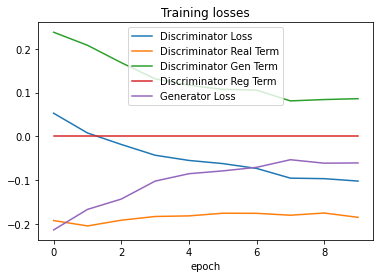

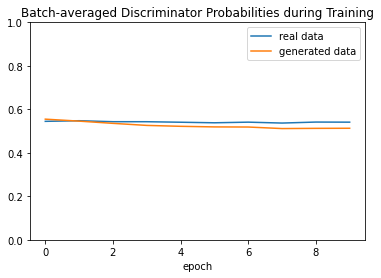

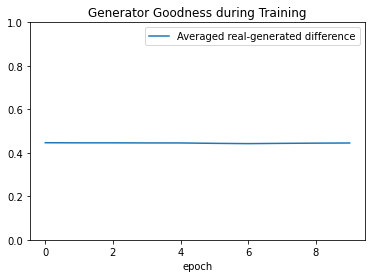

In [18]:
plt.title("Training losses")
plt.plot(GANTrainer.losses.T)
plt.xlabel("epoch")
plt.legend(["Discriminator Loss", "Discriminator Real Term", "Discriminator Gen Term", "Discriminator Reg Term", "Generator Loss"])
plt.show()

plt.title("Batch-averaged Discriminator Probabilities during Training")
plt.plot(GANTrainer.probs.T)
plt.xlabel("epoch")
plt.ylim(0,1)
plt.legend(["real data", "generated data"])
plt.show()

plt.title("Generator Goodness during Training")
plt.plot(GANTrainer.gen_goodness)
plt.xlabel("epoch")
plt.ylim(0,1)
plt.legend(["Averaged real-generated difference"])
plt.show()

Discriminator p(x_gen = real): 53%
Discriminator p(x_real = real) = 53%


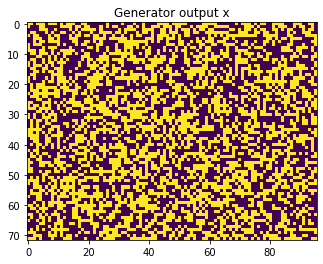

In [19]:
Gen, Dis = trained_GAN
quick_test(Gen, Dis)

## Junk & quick tests